# 로지스틱 회귀

가계 대출 여부 분류하기 (0 대출 안함, 1 대출 함)

[1. statsmodels.api의 Logit 사용](#1.-statsmodels.api의-Logit-사용)<br>
[2. sklearn의 LogisticRegression 사용](#2.-sklearn의-LogisticRegression-사용)

`scikit-learn`의 `linear_model` 라이브러리

- `LogisticRegression`: 로지스틱 회귀 모델 생성
   - `penalty`: 과적합을 줄이기 위한 규제방식
   - `C` : 규제강도 (작을수록 규제가 강하다)
   - `max_iter`: 경사하강법 반복횟수

In [ ]:
"""
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, 
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',random_state=None, solver='lbfgs', 
                   tol=0.0001, verbose=0, warm_start=False)
"""

In [67]:
# 필요한 라이브러리 불러오기

import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

**데이터 전처리**

kaggle의 Bank Personal Loan 데이터를 전처리하여 대출 여부를 분류하기 위한 형태로 만들어준다.

In [32]:
data = pd.read_csv('../input/personal-loan-modeling/Bank_Personal_Loan_Modelling.csv')
data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [33]:
# 결측치 처리
data = data.dropna()

# 의미없는 변수 제거
data = data.drop(['ID', 'ZIP Code'], axis=1)

# 회귀분석을 위한 상수항 추가
data = sm.add_constant(data, has_constant = "add")
data.head()

,const,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1.0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,1.0,45,19,34,3,1.5,1,0,0,1,0,0,0
2,1.0,39,15,11,1,1.0,1,0,0,0,0,0,0
3,1.0,35,9,100,1,2.7,2,0,0,0,0,0,0
4,1.0,35,8,45,4,1.0,2,0,0,0,0,0,1


In [34]:
loan_data = data[data.columns.difference(['Personal Loan'])]
loan_target = data['Personal Loan']

In [35]:
loan_data.head()

,Age,CCAvg,CD Account,CreditCard,Education,Experience,Family,Income,Mortgage,Online,Securities Account,const
0,25,1.6,0,0,1,1,4,49,0,0,1,1.0
1,45,1.5,0,0,1,19,3,34,0,0,1,1.0
2,39,1.0,0,0,1,15,1,11,0,0,0,1.0
3,35,2.7,0,0,2,9,1,100,0,0,0,1.0
4,35,1.0,0,1,2,8,4,45,0,0,0,1.0


In [36]:
loan_target.head()

0    0
1    0
2    0
3    0
4    0
Name: Personal Loan, dtype: int64

## 1. statsmodels.api의 Logit 사용

### 1-1. 모델 생성 및 학습

In [38]:
X_train, X_test, y_train, y_test = train_test_split(loan_data, loan_target, test_size = 0.2, random_state = 30)

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

4000 1000
4000 1000


**로지스틱회귀 모델 학습**

newton을 지정하여 로지스틱 회귀 모델을 적합할 때 최적화 기법을 사용하자.

In [39]:
classifier = sm.Logit(y_train, X_train)
results = classifier.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.131067
         Iterations 9


**모델 학습 결과 확인**

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3988
Method:                           MLE   Df Model:                           11
Date:                Sun, 08 Aug 2021   Pseudo R-squ.:                  0.5898
Time:                        12:03:05   Log-Likelihood:                -524.27
converged:                       True   LL-Null:                       -1278.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.0510      0.066     -0.770      0.441      -0.181       0.079
CCAvg                  0.1124      0.044      2.572      0.010       0.027       0.198
CD Account             3.5996      0.354     10.165      0.000       2.906       4.294
CreditCard            -1.2199      0.234     -5.223      0.000      -1.678      -0.762
Education              1.6969      0.127     13.412      0.000       1.449       1.945
Experience             0.0549      0.066      0.836      0.403      -0.074       0.184
Family                 0.6711      0.082      8.183      0.000       0.510       0.832
Income                 0.0545      0.003     18.757      0.000       0.049       0.060
Mortgage               0.0001      0.001      0.210      0.834      -0.001       0.001
Online                -0.6553      0.173     -3.780      0.000      -0.995      -0.315
Securities Account    -0.4446      0.303     -1.466      0.143      -1.039       0.150
const                -11.9182      1.781     -6.692      0.000     -15.409      -8.427
======================================================================================
"""

**회귀계수 확인**

In [41]:
results.params

Age                   -0.051033
CCAvg                  0.112421
CD Account             3.599587
CreditCard            -1.219857
Education              1.696898
Experience             0.054921
Family                 0.671131
Income                 0.054488
Mortgage               0.000129
Online                -0.655268
Securities Account    -0.444622
const                -11.918174
dtype: float64

위의 결과는 log 형태가 취해진 결과이기 때문에 이를 활용하기 위해서는 exp를 취해주어야한다.

- 나이가 한 살 많을수록 대출할 확률이 0.95배 높다.
- 수입이 1단위 높을수록 대출할 확률이 1.05배 높다. 
- 가족 구성원수가 1명 많을수록 대출할 확률이 1.95배 높다. 

In [42]:
np.exp(results.params)

Age                    0.950248
CCAvg                  1.118984
CD Account            36.583133
CreditCard             0.295272
Education              5.456993
Experience             1.056457
Family                 1.956449
Income                 1.056000
Mortgage               1.000129
Online                 0.519303
Securities Account     0.641067
const                  0.000007
dtype: float64

In [44]:
y_pred = results.predict(X_test)
y_pred

2192    0.000107
911     0.199300
3061    0.026812
3382    0.162581
2939    0.004526
          ...   
4867    0.061102
2430    0.005762
856     0.008641
3457    0.004654
3550    0.001481
Length: 1000, dtype: float64

### 1-2. threshold 설정

threshold 이상이면 1, 그렇지 않으면 0으로 판단하도록 하는 함수를 만든다.

In [45]:
def cut_off(y, threshold):
    Y = y.copy()
    Y[Y > threshold] = 1
    Y[Y <= threshold] = 0
    return(Y.astype(int))

In [19]:
Y_pred = cut_off(y_pred, 0.5)
Y_pred

2192    0
911     0
3061    0
3382    0
2939    0
       ..
4867    0
2430    0
856     0
3457    0
3550    0
Length: 1000, dtype: int64

### 1-3. 성능 평가

threshold가 0.5인 경우 정확도는 약 93.5%이다.<br>
threshold를 변경하면서 정확도 값을 확인해보자.

In [47]:
confusion_matrix(y_test, Y_pred)

array([[910,   0],
       [ 65,  25]])

In [48]:
accuracy_score(y_test, Y_pred)

0.935

In [49]:
thresholds = np.arange(0, 1, 0.1)
accuracy = pd.DataFrame(columns = ['accuracy'])

for threshold in thresholds:
    Y_pred = cut_off(y_pred, threshold)
    accuracy.loc[threshold] = accuracy_score(y_test, Y_pred)

accuracy.index.name = 'threshold'
accuracy.columns.name = 'performance'
accuracy

performance,accuracy
threshold,
0.0,0.090
0.1,0.899
0.2,0.934
0.3,0.943
0.4,0.949
0.5,0.952
0.6,0.952
0.7,0.951
0.8,0.945


AUC: 0.9627228327228328


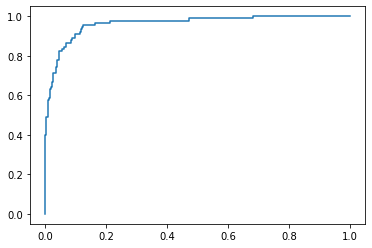

In [50]:
ㅊ

---

## 2. sklearn의 LogisticRegression 사용

sklearn의 linear_model 중 LogisticRegression을 사용해서 모델 학습과 예측을 해보자.

### 2-1. 스케일링

StandardScaler를 통해 평균과 표준편차 사용하여 표준화해준다.

In [68]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2-2. 모델 학습

In [69]:
lr = LogisticRegression(C=0.1, max_iter=100)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1)

### 2-3. 예측

이 때 threshold는 디폴트 값인 0.5이며 정확도는 약 95% 이다.

- predict: 테스트 데이터의 예측된 결과 (0 또는 1의 예측 class) 
- predict_proba: 데이터의 예측 class가 아닌 예측된 확률 (0과 1사이의 예측된 확률값)

In [72]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [77]:
lr.predict(X_train)

array([1, 0, 0, ..., 0, 0, 0])

In [78]:
lr.predict_proba(X_test)

array([[9.99648301e-01, 3.51699117e-04],
       [8.09014139e-01, 1.90985861e-01],
       [9.60330939e-01, 3.96690609e-02],
       ...,
       [9.87438902e-01, 1.25610975e-02],
       [9.91591337e-01, 8.40866254e-03],
       [9.96346295e-01, 3.65370462e-03]])

In [74]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.952
0.951


AUC: 0.9627228327228328


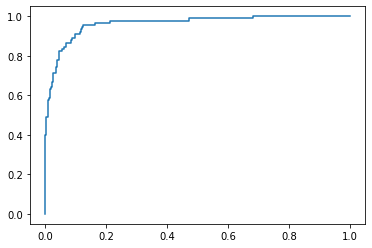

In [79]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
plt.plot(fpr, tpr)

auc = np.trapz(tpr, fpr)
print('AUC:', auc)